In [1]:
import os

import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import hsv_to_rgb


In [2]:
root = "/mnt/home/donti-group-shared/ojas/pfdelta/"

In [3]:
def find_run_folder(run_name):
    """Searches for the folder in 'runs' using glob and ensures the name is
    unique."""
    # Assuming the root folder is "runs"
    run_pattern = os.path.join(root, "runs", "**", run_name)
    matching_folders = glob.glob(run_pattern, recursive=True)

    if len(matching_folders) == 0:
        print(f"Error: No folder named '{run_name}' found in {run_pattern}.")
        return None
    elif len(matching_folders) > 1:
        print(
            f"Error: Multiple folders with the name '{run_name}' found."
            + "Please ensure the name is unique."
        )
        return None
    else:
        return matching_folders[0]  # Return the unique matching folder

In [15]:
def parse_and_store_all(run_name, error_key="PBL Mean"):
    # Extract hyperparams from run name
    # TODO: Make this more robust
    # parts = run_name.split("_")
    # layers = int(parts[2])
    # hidden = int(parts[4])
    # lr = float(parts[6].replace("e", "e"))  # preserve scientific notation
    # epochs = int(parts[8])
    # run_id = int(parts[9])
    
    parts = run_name.split("_")
    case = int(parts[2])
    layers = int(parts[4])
    hidden = int(parts[6])
    lr = float(parts[8].replace("e", "e"))  # preserve scientific notation
    epochs = int(parts[10])
    run_id = int(parts[13])

    # Find the run folder
    run_folder = find_run_folder(run_name)
    if run_folder is None:
        return

    # Load JSONs
    with open(os.path.join(run_folder, "train.json")) as f:
        train_data = json.load(f)
    with open(os.path.join(run_folder, "val.json")) as f:
        val_data = json.load(f)
    with open(os.path.join(run_folder, "summary.json")) as f:
        summary_data = json.load(f)

    # Get full train loss over epochs
    train_epochs = sorted(train_data.keys(), key=int)
    train_loss = [train_data[e].get(error_key, None) for e in train_epochs]

    # Get full val loss over epochs
    val_epochs = sorted(val_data.keys(), key=int)
    val_loss = [val_data[e][0].get(error_key, None) for e in val_epochs]

    # Store hyperparameters
    data_df[run_id] = {
        "case": case,
        "run_id": run_id,
        "layers": layers,
        "hidden": hidden,
        "lr": lr,
        "epochs": epochs,
        "val": summary_data["val"][0][error_key],
        "train": summary_data["train"][error_key],
        "train_over_time": train_loss,
        "val_over_time": val_loss,
        "train_data": train_data,
        "error_key": error_key,
        "run_name": run_name,
    }
    

In [5]:
def parse_sweep(sweep_folder, error_key="PBL Mean"):
    sweep_folder = os.path.join(root, "runs", sweep_folder)
    for run_folder in os.listdir(sweep_folder):
        if (run_folder.startswith("zold")):
            continue
        parse_and_store_all(run_folder, error_key)


In [6]:
def heatmap():
    g = sns.FacetGrid(
        data_df,
        row="lr",
        col="epochs",
        margin_titles=True
    )
    g.map_dataframe(
        lambda data, color: sns.heatmap(
            data.pivot(index="layers", columns="hidden", values="val").astype(float),
            cbar=False,
            cmap="RdYlGn_r",
            fmt=".4f",
            annot=True
        )
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Validation Heatmaps for (layers x hidden)")
    plt.show()

In [7]:
def heatmap_matrix():
    hyperparams = ['layers', 'hidden', 'lr', 'epochs']

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i, hp_i in enumerate(hyperparams):
        for j, hp_j in enumerate(hyperparams):
            ax = axes[i, j]
            if i == j:
                # Plot distribution of validation error across this hyperparameter
                sns.violinplot(x=hp_i, y='val', data=data_df, ax=ax)
            else:
                # Use pivot table for 2D aggregation
                pivot = data_df.pivot_table(index=hp_j, columns=hp_i, values='val', aggfunc='mean')
                pivot = pivot.astype(float).fillna(np.nan)
                sns.heatmap(pivot, ax=ax, cmap='RdYlGn_r', cbar=(i==0 and j==3), annot=True, fmt=".4f")  # only show colorbar once
            if i == 3:
                ax.set_xlabel(hp_j)
            else:
                ax.set_xlabel("")
            if j == 0:
                ax.set_ylabel(hp_i)
            else:
                ax.set_ylabel("")
            
            if i == 0:
                ax.set_title(hp_j)
            if j == 0:
                ax.set_ylabel(hp_i)
            

    plt.tight_layout()
    plt.show()

In [8]:
def parallel_coordinates():
    cols_to_scale = ["layers", "hidden", "epochs", "lr", "val"]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_df[cols_to_scale])
    scaled_df = pd.DataFrame(scaled, columns=cols_to_scale)

    # Add back original values
    for col in cols_to_scale:
        scaled_df[f"{col}_orig"] = data_df[col]

    # Manually define dimensions for better hover text
    dimensions = []
    for col in cols_to_scale:
        dimension = dict(
            range=[0, 1],
            label=f"{col}",
            values=scaled_df[col],
            tickvals=[0, 0.5, 1],
            ticktext=[
                f"{scaled_df[col + '_orig'].min()}",
                f"{scaled_df[col + '_orig'].mean():.4f}",
                f"{scaled_df[col + '_orig'].max()}"
            ]
        )
        dimensions.append(dimension)

    # Build figure
    fig = go.Figure(
        data=go.Parcoords(
            line=dict(
                color=scaled_df["val"],
                colorscale="RdYlGn_r",
                showscale=True,
                cmin=0,
                cmax=1
            ),
            dimensions=dimensions
        )
    )

    fig.update_layout(title="Parallel Coordinates")
    fig.show()

In [9]:
def three_d_scatter():
    my_new_plot_df = data_df[["layers", "hidden", "val", "epochs", "lr", "run_id"]].dropna()
    my_new_plot_df[["layers", "hidden", "val", "epochs", "lr"]] = my_new_plot_df[["layers", "hidden", "val", "epochs", "lr"]].astype(float)

    fig = px.scatter_3d(
        my_new_plot_df,
        x="layers",
        y="hidden",
        z="lr",
        color="val",
        size="epochs",
        hover_name="run_id",
        title="3D Scatter: Layers × Hidden × Val",
        color_continuous_scale="RdYlGn_r",
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
    fig.show()

In [10]:
def pairplot():
    sns.pairplot(data_df, vars=["layers", "hidden", "lr", "epochs", "val"], corner=True)
    plt.suptitle("Pairwise Hyperparameter Relationships", y=1.02)
    plt.tight_layout()
    plt.show()

In [11]:
def pca_plot():

    # Assume `data_df` is your DataFrame with hyperparameters and val score
    hyperparam_cols = ["layers", "hidden", "epochs", "lr"]
    X_scaled = StandardScaler().fit_transform(data_df[hyperparam_cols])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame()
    pca_df["PC1"] = pca_result[:, 0]
    pca_df["PC2"] = pca_result[:, 1]
    pca_df["val"] = data_df["val"]
    pca_df["run_id"] = data_df.get("run_id", data_df.index)

    for col in hyperparam_cols:
        pca_df[col] = data_df[col]

    pca_df["val"] = pd.to_numeric(pca_df["val"], errors="coerce")

    fig = px.scatter(
        pca_df,
        x="PC1",
        y="PC2",
        color=pca_df["val"],  # pass Series explicitly, not just "val"
        hover_data=["run_id"] + hyperparam_cols,
        color_continuous_scale="RdYlGn_r",  # or "Turbo", "Plasma"
        title="PCA of Hyperparameters Colored by Validation Score"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Validation Score"
        )
    )

    fig.show()

In [12]:
def old_plot_train_val_over_time():
    total_runs = len(data_df)
    colors = [hsv_to_rgb([i/total_runs, 1, 1]) for i in range(total_runs)]

    plt.figure(figsize=(10, 6))
    plt.xlabel("Training point")
    plt.ylabel(f"{data_df['error_key'][0]}")
    plt.title(f"{data_df['run_name'][0]} - {data_df['error_key'][0]}")
    for run_num in range(total_runs):
        epoch_list = list(range(data_df["epochs"][run_num]))

        train_over_time = data_df["train_over_time"][run_num]

        plt.plot(train_over_time, marker="o", linestyle="-", color=colors[run_num], label=f"Train {run_num}")

        val_over_time = data_df["val_over_time"]
        for i in range(len(val_over_time)):
            val_data = val_over_time[i]
            plt.plot(val_data, marker=',', linestyle='--', color=colors[run_num], alpha=0.5)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:

def plot_train_val_interactive(data_df, sweep_name=""):
    total_runs = len(data_df)
    # recreate your custom color map
    colors = [f"rgb{tuple((hsv_to_rgb([i/total_runs, 1, 1])*255).astype(int))}"
              for i in range(total_runs)]

    # Create an empty Figure
    fig = go.Figure()

    for run_num in range(total_runs):
        run_name   = data_df["run_name"][run_num]
        err_key    = data_df["error_key"][run_num]
        train_data = data_df["train_over_time"][run_num]
        val_series = data_df["val_over_time"][run_num]  # assuming list of lists

        # Add the train-over-time trace
        fig.add_trace(go.Scatter(
            x=list(range(len(train_data))),
            y=train_data,
            mode='lines+markers',
            name=f"Train {run_num}",
            marker=dict(symbol='circle'),
            line=dict(color=colors[run_num]),
            hovertemplate=f"Run: {run_name}<br>Epoch: %{{x}}<br>{err_key}: %{{y}}<extra></extra>"
        ))

        
        
        fig.add_trace(go.Scatter(
            x=list(range(len(val_series))),
            y=val_series,
            mode='lines',
            line=dict(
                dash='dot',
                color=colors[run_num],
                # width=1
            ),
            opacity=0.8,
            showlegend=False,  # don't show legend for validation traces
        ))

    # Update layout for axis labels and title
    fig.update_layout(
        title=f"{sweep_name} - {data_df['error_key'][0]}",
        xaxis=dict(
            title="Epoch",
            rangeslider=dict(visible=True),
            type="linear"
        ),
        yaxis_title=data_df['error_key'][0],
        legend_title="Legend",
        template="plotly_white",
        width=900,
        height=550
    )

    fig.show()

---

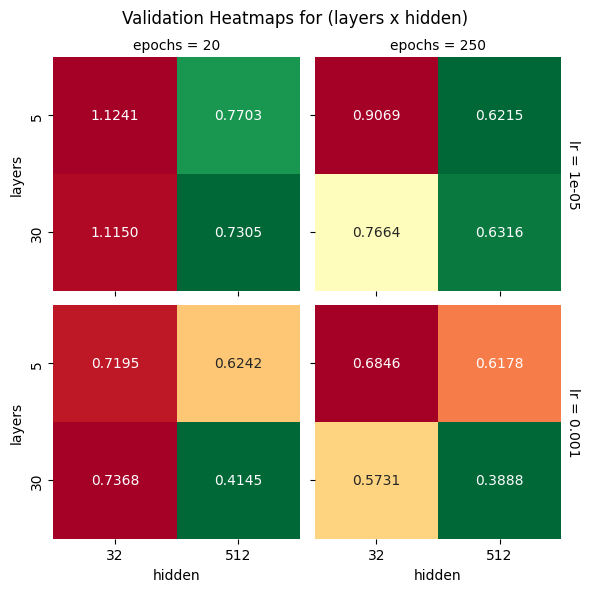

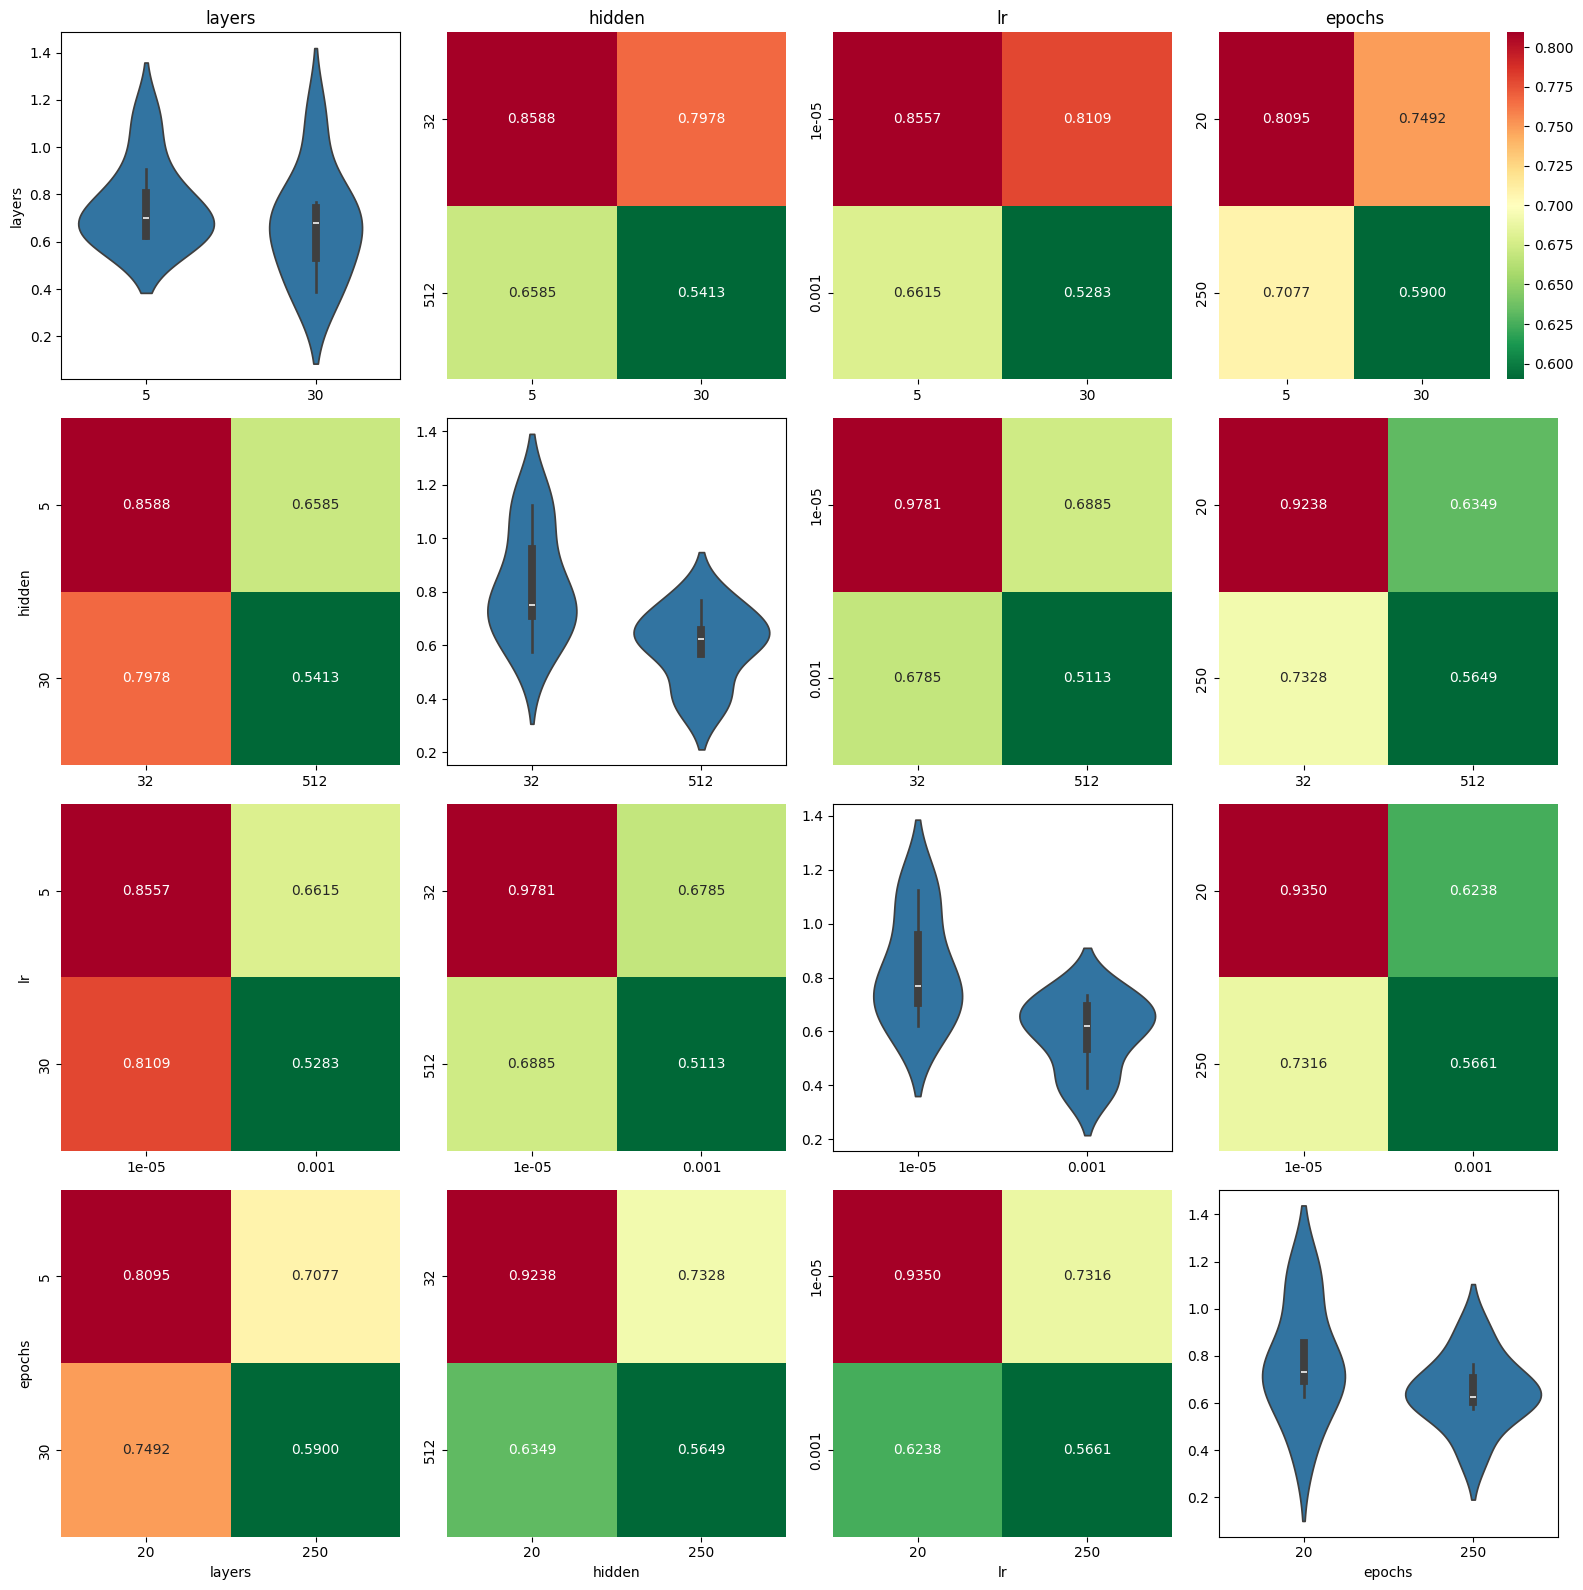

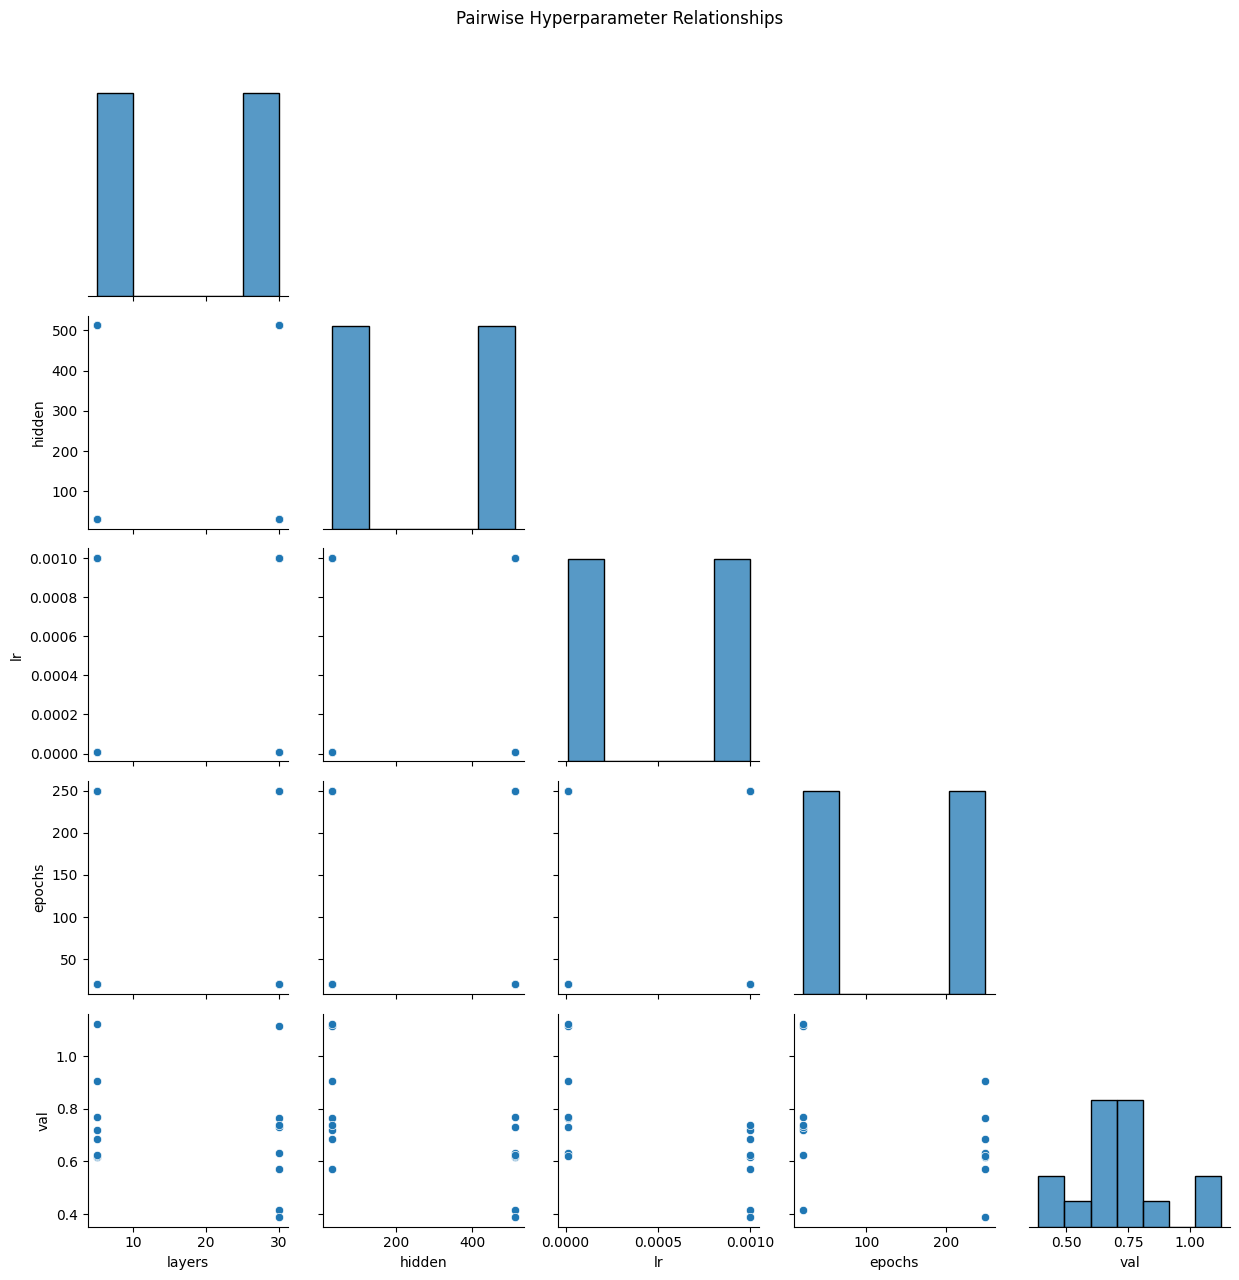

In [14]:
data_df = pd.DataFrame()
parse_sweep("graph_conv/graph_conv_sweep_0710")
data_df = data_df.T

heatmap()
heatmap_matrix()
parallel_coordinates()
three_d_scatter()
pairplot()
pca_plot()
plot_train_val_interactive(data_df, sweep_name="graph_conv/graph_conv_sweep_0710")

In [ ]:
data_df = pd.DataFrame()
parse_sweep("graph_nn_conv/graph_nn_conv_sweep_0711")
data_df = data_df.T

heatmap()
heatmap_matrix()
parallel_coordinates()
three_d_scatter()
pairplot()
pca_plot()
plot_train_val_interactive(data_df, sweep_name="graph_nn_conv/graph_nn_conv_sweep_0711")

In [ ]:
data_df = pd.DataFrame()
parse_sweep("gat/gat_sweep_hidden_fixed_0715")
data_df = data_df.T

heatmap()
heatmap_matrix()
parallel_coordinates()
three_d_scatter()
pairplot()
pca_plot()
plot_train_val_interactive(data_df, sweep_name="gat/gat_sweep_hidden_fixed_0715")

In [ ]:

data_df = pd.DataFrame()
parse_sweep("sageconv/sageconv_sweep_0715")
data_df = data_df.T

heatmap()
heatmap_matrix()
parallel_coordinates()
three_d_scatter()
pairplot()
pca_plot()
plot_train_val_interactive(data_df, sweep_name="sageconv/sageconv_sweep_0715")

---

In [ ]:
data_df = pd.DataFrame()
parse_sweep("graph_conv/graph_conv_sweep_0710", error_key="MSELoss")
data_df = data_df.T
plot_train_val_interactive(data_df, sweep_name="graph_conv/graph_conv_sweep_0710")

data_df = pd.DataFrame()
parse_sweep("graph_nn_conv/graph_nn_conv_sweep_0711", error_key="MSELoss")
data_df = data_df.T
plot_train_val_interactive(data_df, sweep_name="graph_nn_conv/graph_nn_conv_sweep_0711")

data_df = pd.DataFrame()
parse_sweep("gat/gat_sweep_hidden_fixed_0715", error_key="MSELoss")
data_df = data_df.T
plot_train_val_interactive(data_df, sweep_name="gat/gat_sweep_hidden_fixed_0715")

data_df = pd.DataFrame()
parse_sweep("sageconv/sageconv_sweep_0715", error_key="MSELoss")
data_df = data_df.T
plot_train_val_interactive(data_df, sweep_name="sageconv/sageconv_sweep_0715")


---

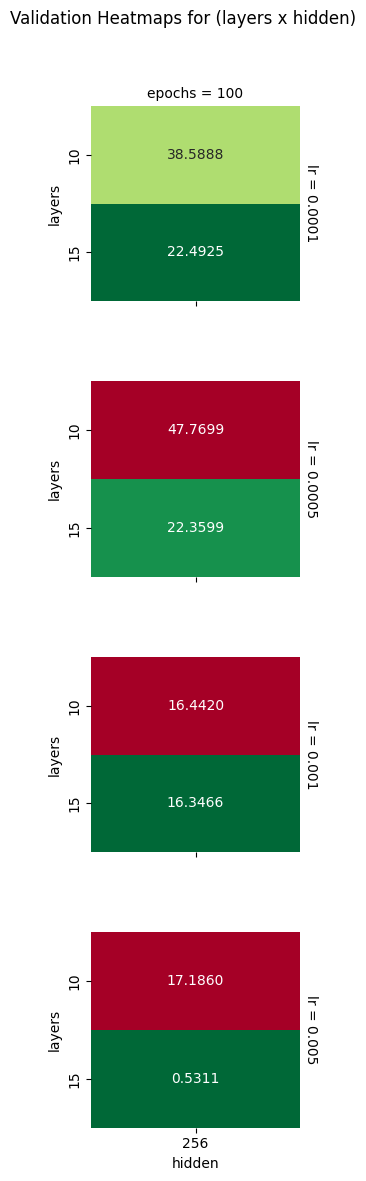

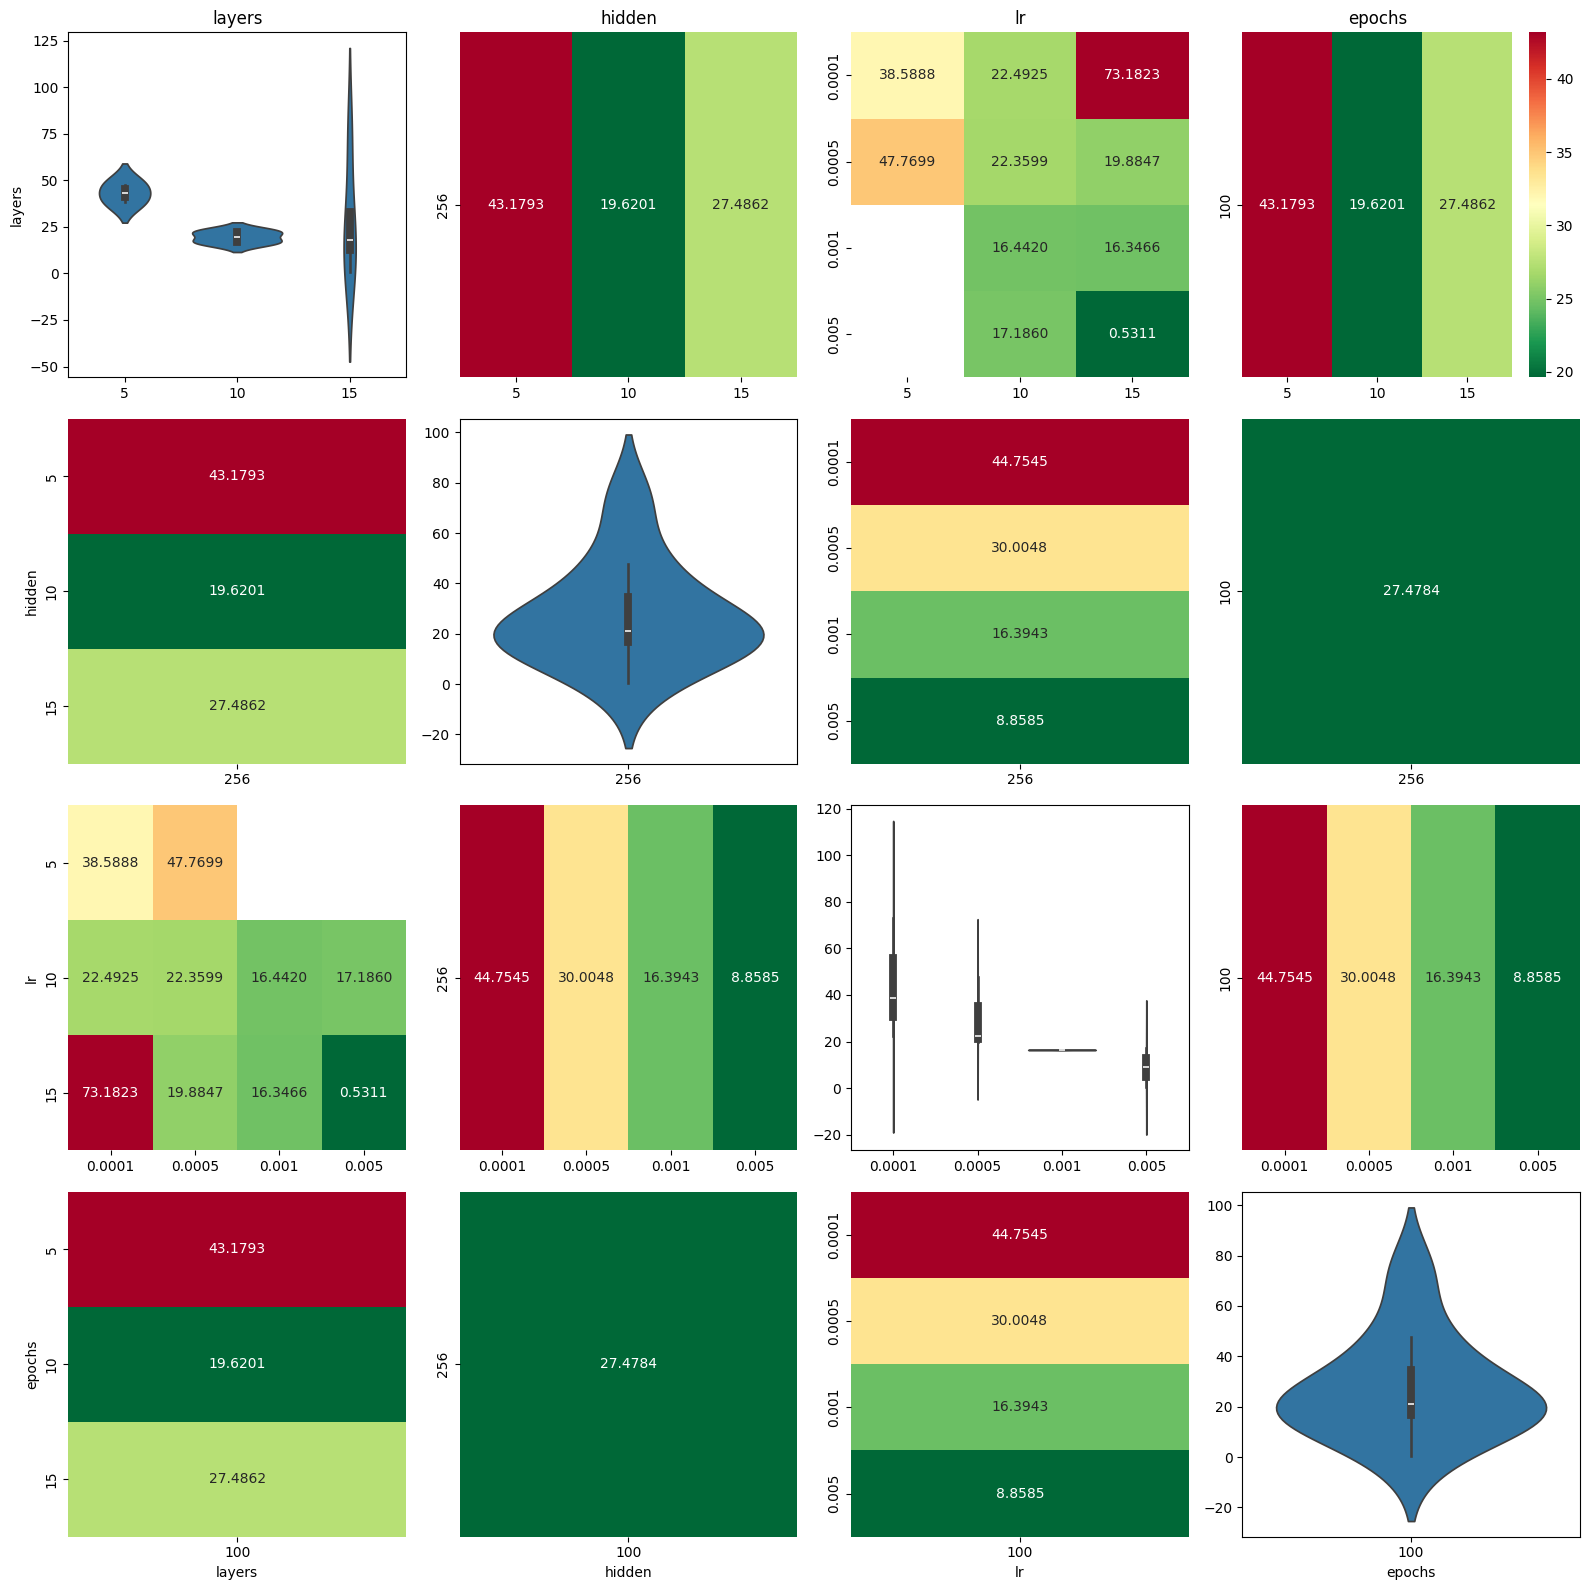

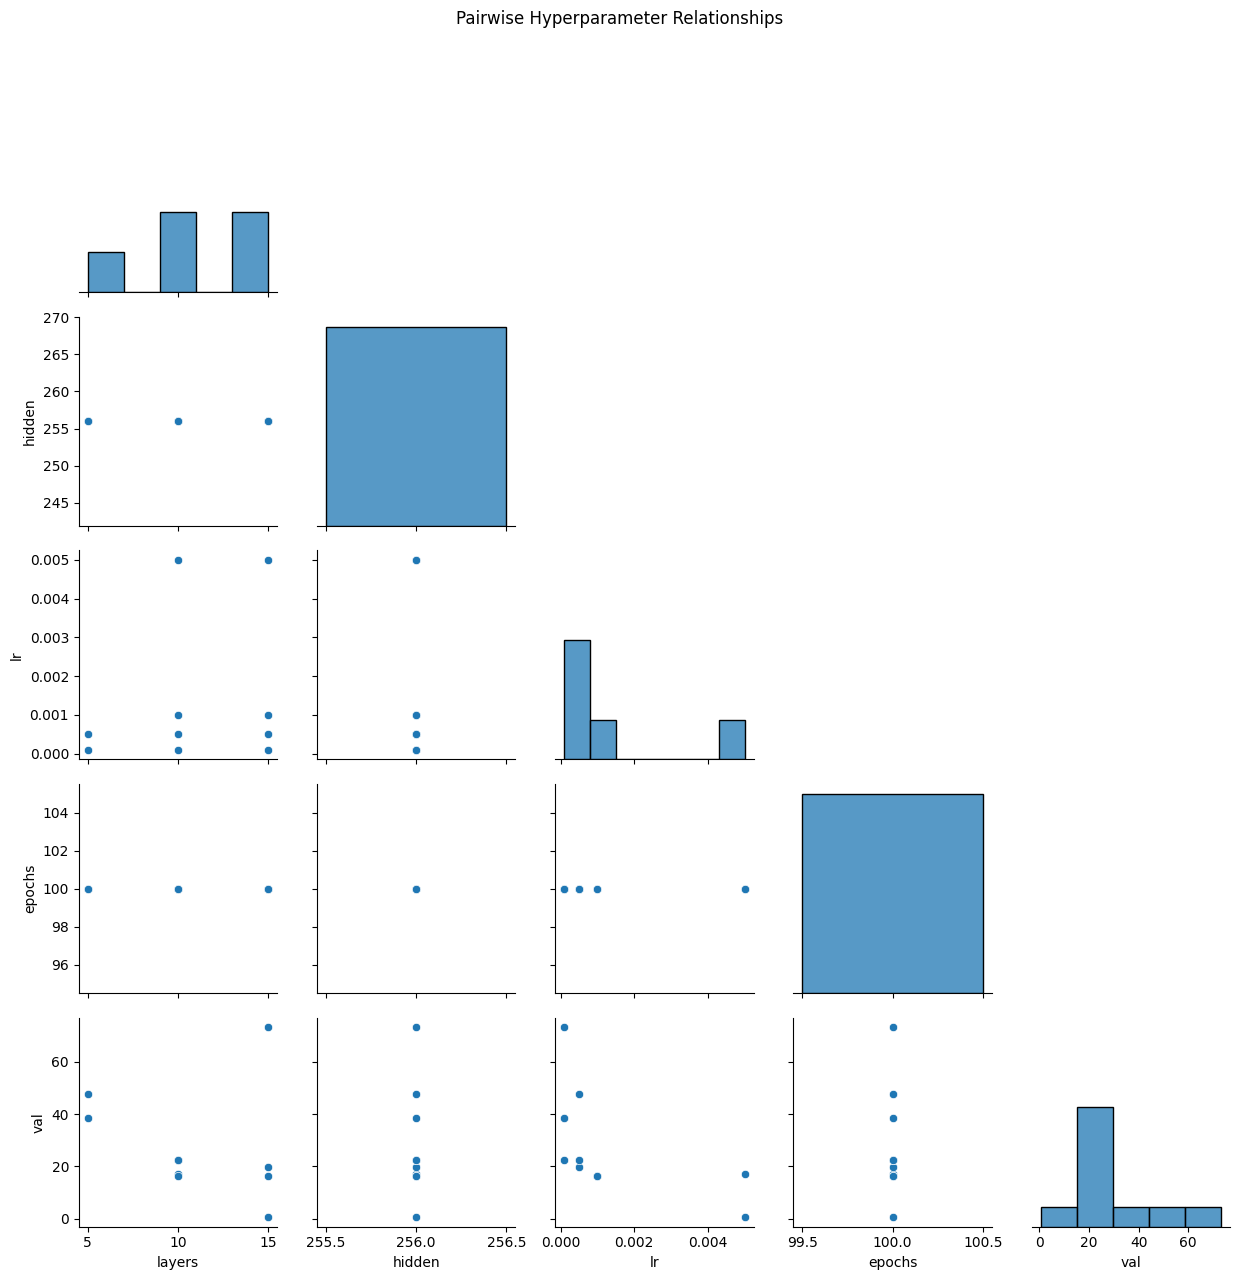

KeyError: 0

In [16]:
data_df = pd.DataFrame()
parse_sweep("gen_msrp_fe/run1/task3.1/case14/graphconv")
data_df = data_df.T

heatmap()
heatmap_matrix()
parallel_coordinates()
three_d_scatter()
pairplot()
pca_plot()
plot_train_val_interactive(data_df, sweep_name="gen_msrp_fe/run1/task3.1/case14/graphconv")
